---

Hi **Michael** and **Dan**,

As planned, we have tested the efficacy of **A deaminase** on templates with **methyl-A (meA)** modifications.

## MiSeq data location

```text
/mnt/wigstore3/data/checkpointcharlie2/inessa/250707_M06142_0497_000000000-M2RFJ/Alignment_1/20250708_193955/Fastq
```

## FASTQ files to inspect

* `DB1_S3_L001_R1_001.fastq.gz`
* `DB1_S3_L001_R2_001.fastq.gz`
* `DB2_S4_L001_R1_001.fastq.gz`
* `DB2_S4_L001_R2_001.fastq.gz`
* `DB3_S5_L001_R1_001.fastq.gz`
* `DB3_S5_L001_R2_001.fastq.gz`
* `DB4_S6_L001_R1_001.fastq.gz`
* `DB4_S6_L001_R2_001.fastq.gz`
* `DB5_S7_L001_R1_001.fastq.gz`
* `DB5_S7_L001_R2_001.fastq.gz`
* `DB6_S8_L001_R1_001.fastq.gz`
* `DB6_S8_L001_R2_001.fastq.gz`

## Template information

### DB1 & DB2 (Control – **no meA**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

### DB3 & DB4 (**contains meA**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

### DB5 & DB6 (**meA with alternate modification patterns**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

> **Note:** *meA should **not** be converted to **G**.*

### Read structure

```
read 1: ""|A|TG|GAC + N(15, copy tag) + AGCCAGGAGACAGAGC + TCATGTTTAACGCAGGTGAA + T(15) + AGATGCTGAAGATCAGTTGG + N(15, template tag)

read 2: ""|G|CA|TGT + GTTGCTTGGTGCTGGT + N(15, template tag) + CCAACTGATCTTCAGCATCT + A(15) + TTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGCT + N(15, copy tag)
```

Both meA-containing templates also include flanking **meA** modifications, which should clarify conversion patterns.

## Library-prep procedure

1. **A-conversion**
2. **15 cycles** of linear amplification
3. **1 cycle** linear extension to create dsDNA
4. Final **PCR** to generate libraries

Let me know if you need further information or clarification.

Thanks,
**Zihua**

The marking of the meA were lost in the conversion to markdown. 
Here, they are shown as "X".


```text
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AAAAAAAAAAAAAAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGXTCTTCAGCATCT AAXAAAXAAAXAAXA TTCACCTGCG TTXAACATGA GCTCTGTCTC CTGGC
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AXAAAXXXAAAXXAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC
```

In [ ]:

# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import re
from collections import defaultdict
import yaml
from read_break.parser import ReadParser
from read_break.logic import flatten_dot
from read_break.io import FastqReader
import pandas as pd
import numpy as np



root_dir = Path(os.getcwd()).parent
root_dir

data_dir = Path( r"Z:\mnt\wigstore3\data\checkpointcharlie2\inessa\250707_M06142_0497_000000000-M2RFJ\Alignment_1\20250708_193955\Fastq" )

# directory that contains the MiSeq run
RUN_DIR = Path(data_dir)          
# regex: capture key = <field1>_<field2>, read = 1 or 2
PAT = re.compile(r'^(?P<key>[^_]+_[^_]+)_L\d{3}_R(?P<read>[12])_\d{3}\.fastq\.gz$')
libs: dict[str, dict[str, Path]] = defaultdict(lambda: {"R1": None, "R2": None})
for f in RUN_DIR.glob("*.fastq.gz"):
    m = PAT.match(f.name)
    if not m:
        continue                       # skip unexpected names
    key, read = m.group("key", "read")
    libs[key][f"R{read}"] = f.resolve()

# sanity-check: complain if any library is missing a mate
missing = {k: v for k, v in libs.items() if None in v.values()}
if missing:
    raise ValueError(f"Mate not found for: {missing}")

## restrict to keys that start with 'DB'
libs = {k: v for k, v in libs.items() if k.startswith("DB")}
key_list = sorted(libs.keys())
print(f"\nKeys: {key_list}")

broken_reads = dict()

for key in key_list:
    read1_filename, read2_filename = libs[key]["R1"], libs[key]["R2"]
    print(f"\nRead 1: {read1_filename}\nRead 2: {read2_filename}")


    ## get the parser configuration

    parsers_dir = root_dir / "parsers"
    parse_config = parsers_dir / "a_deaminate_2025_07_10.yaml"

    parser_cfg = yaml.safe_load( parse_config.read_text() )

    parser = ReadParser(parser_cfg,
                        parser_cfg['params'])

    print(parser)


    ## collect results
    results = []

    MAX_READS = np.inf  # limit for testing, set to None for no limit
    with FastqReader(read1_filename, read2_filename) as reader:
        for ind, read_pair in enumerate( reader ):
            if ind >= MAX_READS:
                break
            if ind % 10000 == 0:        
                parse_log = flatten_dot( parser.get_parse_log() )        
                if ind == 0:
                    print('sample', *list( parse_log.keys() ), sep="\t")
                else:
                    print(key, *list( parse_log.values() ), sep="\t")                            
            ctx = parser.parse(*read_pair)
            if not ctx or ctx.get("status") != "ok":
                continue
            else:
                results.append(ctx)

    parser.get_parse_log()
    df = pd.DataFrame.from_dict(results)
    broken_reads[key] = df
    print(f"\n{len(df)} reads parsed for {key}.")

    

In [ ]:
from pathlib import Path
import pandas as pd

# ------------------------------------------------------------------
out_root = Path("parsed_output")          # ❶ top-level output dir
out_root.mkdir(exist_ok=True)

for sample, df in broken_reads.items():
    # ❷ choose ONE of the blocks below -----------------------------

    # --- (a) CSV --------------------------------------------------
    # csv_path = out_root / f"{sample}.csv.gz"   # gzip-compressed
    # df.to_csv(csv_path, index=False, compression="gzip")

    # --- (b) Parquet ---------------------------------------------
    pq_path = out_root / f"{sample}.parquet"
    df.to_parquet(pq_path, index=False, compression="zstd")  # fast + compact

print(f"✓ Wrote {len(broken_reads)} sample tables to {out_root.resolve()}")


✓ Wrote 6 sample tables to C:\Users\levy\Repos\read-break\notebooks\parsed_output


DB4_S6


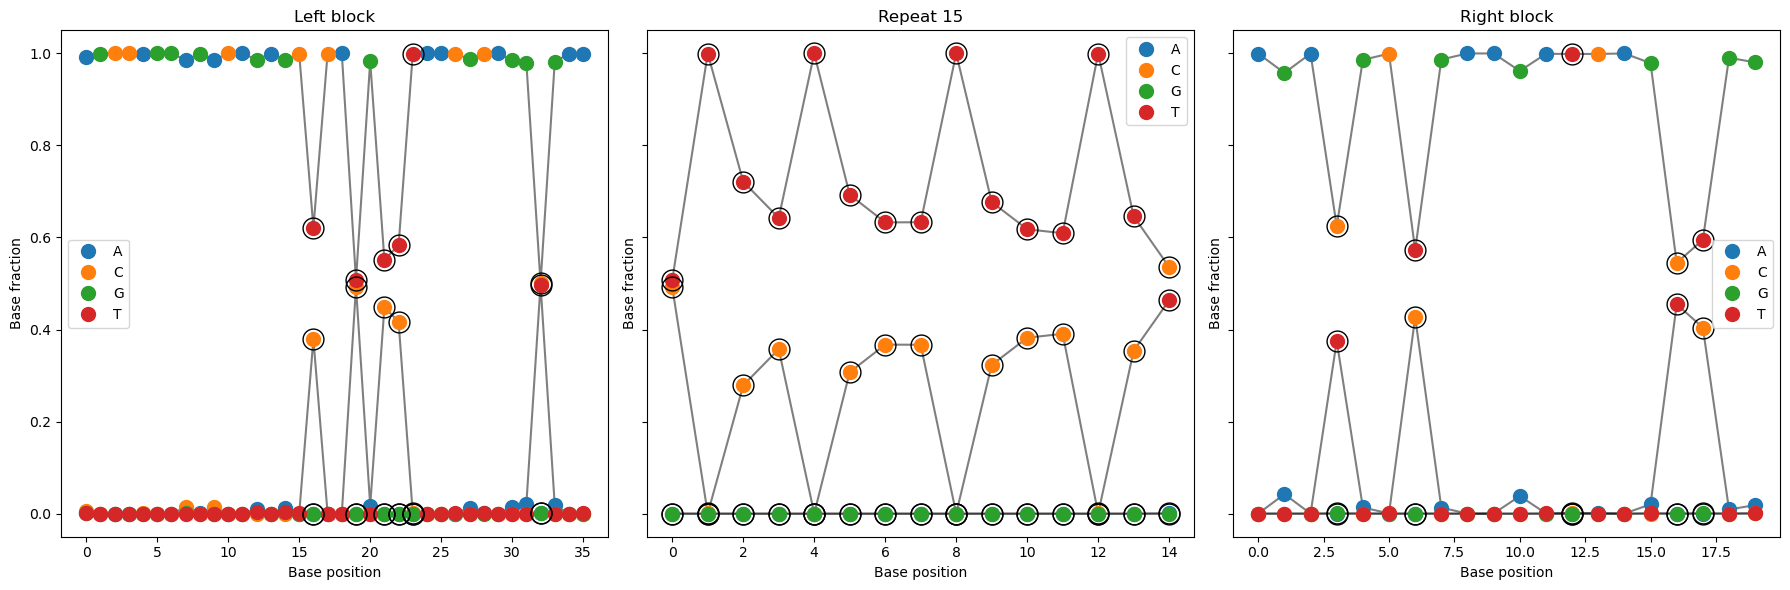

In [87]:
keys = np.sort(list( broken_reads.keys()))

key = keys[3]

df = broken_reads[key]
print(key)
strings = [
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AAAAAAAAAAAAAAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC",
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGXTCTTCAGCATCT AAXAAAXAAAXAAXA TTCACCTGCG TTXAACATGA GCTCTGTCTC CTGGC",
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AXAAAXXXAAAXXAA TTCACCTGCG TTAAACATGA GCTCTGTCTCCTGGC"]

strings = [s.replace(" ", "") for s in strings]


from read_break.logic import seq_to_int, BASE2INT, BASES
import numpy as np

expected_left_seq = parser_cfg['params']['r1_seq1'] + parser_cfg['params']['r1_seq2']
expected_right_seq = parser_cfg['params']['r1_seq3']

expected_left_int  = np.array( seq_to_int(expected_left_seq) )
expected_right_int = np.array( seq_to_int(expected_right_seq))


left_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["left_block_r1"])), axis=1).values )
right_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["right_block_r1"])), axis=1).values )

dfilter = df['repeat_len_r1'] == 15
repeat15 = np.vstack( df[dfilter].apply(lambda x: np.array( seq_to_int(x["repeat_r1"])), axis=1).values )

from read_break.plot import plot_base_totals
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
left_bits = expected_left_int == BASE2INT['T']
right_bits = expected_right_int == BASE2INT['T']
repeat15_bits = np.ones(repeat15.shape[1], dtype=bool)


plot_base_totals(left_block, left_bits, axes[0], small_marker=20, bit_marker=30, marker='.', normed=True)
plot_base_totals(repeat15, repeat15_bits, axes[1], small_marker=20, bit_marker=30, marker='.', normed=True)
plot_base_totals(right_block, right_bits, axes[2], small_marker=20, bit_marker=30, marker='.', normed=True)
axes[0].set_title("Left block")
axes[1].set_title("Repeat 15")
axes[2].set_title("Right block")
for ax in axes:
    ax.set_xlabel("Base position")
    ax.set_ylabel("Base fraction")
plt.tight_layout()

plt.show()
